In [1]:
# Basic Libraries
import numpy as np
import os 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models


In [2]:
# Load the dataset
dataset_path = r"C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\parking\clf-data"


In [3]:
# Load and split into training (80%) and validation (20%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

Found 6090 files belonging to 2 classes.
Using 4872 files for training.
Found 6090 files belonging to 2 classes.
Using 1218 files for validation.


In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5) # 80% of the validation dataset

In [5]:
# Class names
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['empty', 'not_empty']


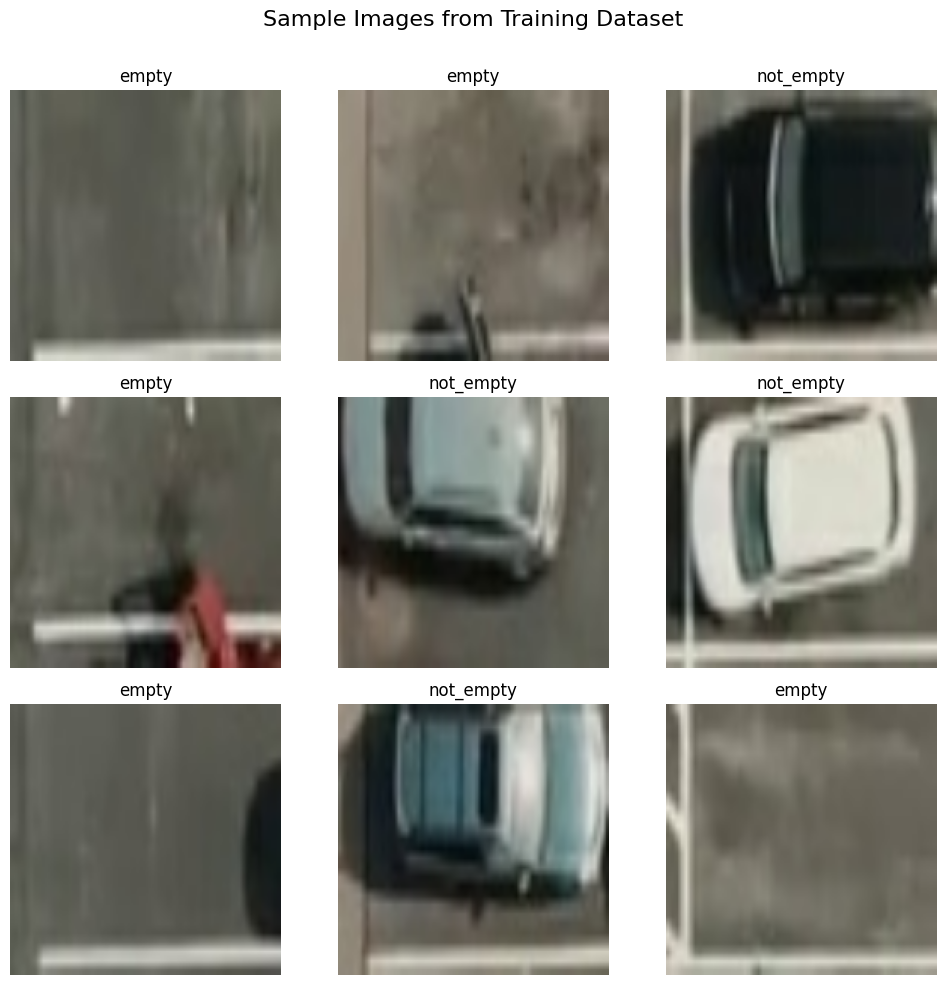

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [7]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Build the model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


c:\Users\PC\anaconda3\envs\my_environment\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.8945 - loss: 0.2775 - val_accuracy: 0.9984 - val_loss: 0.0064
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9992 - val_loss: 0.0072
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9926 - loss: 0.0221 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 1.0000 - loss: 1.9404e-04 - val_accuracy: 0.9992 - val_loss: 7.7958e-04
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 1.0000 - loss: 5.5302e-05 - val_accuracy: 1.0000 - val_loss: 6.5696e-04
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 5.1191e-05 - val_accuracy: 0.9992 - val_loss: 0.0015
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 1.0000 - loss: 2.7894e-05 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 1.0

In [ ]:
# 👟 Data Augmentation Block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Normalize images to [0, 1]
    data_augmentation,  # Apply data augmentation
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting

    # Binary output layer with sigmoid activation (1 output neuron for binary classification)
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['accuracy']
)

# Early stopping to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

In [10]:
class_names

['empty', 'not_empty']

In [11]:
y_true = []
y_pred = []

for X, labels in test_dataset:
    preds = model.predict(X)
    bin_preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(bin_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
len(y_true), len(y_pred)

(224, 224)

In [14]:
conf_matrix = confusion_matrix(y_true, y_pred)

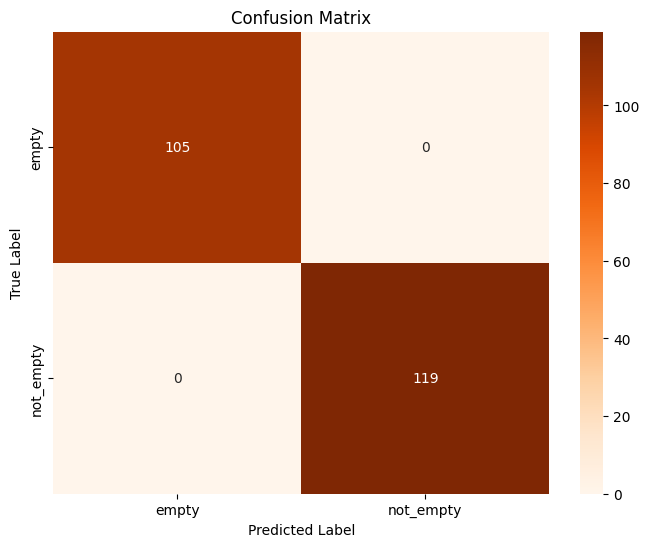

In [15]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [16]:
from sklearn.metrics import classification_report

In [17]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       empty       1.00      1.00      1.00       105
   not_empty       1.00      1.00      1.00       119

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



Deployment

use the mask

maybe analize video?

In [18]:
model.save("my_model.keras")  # Save
model = tf.keras.models.load_model("my_model.keras")  # Load
# keep the model in memory to load later

In [19]:
# how to call the model to use it later
from tensorflow.keras.models import load_model
model = load_model("my_model.keras")

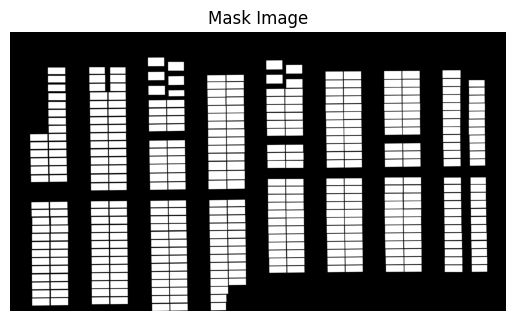

In [20]:
mask_path = r'C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\parking\mask_1920_1080.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Visualize the mask
plt.imshow(mask, cmap='gray')
plt.title("Mask Image")
plt.axis('off')
plt.show()

In [21]:
_, thresh = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(f"There are {len(contours)} parking spots detected.")
# Finding contours (parking spots)

There are 396 parking spots detected.


In [22]:
video_path = r"C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\parking\parking_1920_1080.mp4"
output_dir = r"C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\frames"
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0
saved_count = 0
frame_skip = 100  # Save one every 50 frames

while cap.isOpened() and saved_count < 5:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_skip == 0:
        frame_filename = os.path.join(output_dir, f"frame_{saved_count}.jpg")
        cv2.imwrite(frame_filename, frame)
        print(f"✅ Saved: {frame_filename}")
        saved_count += 1

    frame_count += 1

cap.release()
cv2.destroyAllWindows()

✅ Saved: C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\frames\frame_0.jpg
✅ Saved: C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\frames\frame_1.jpg
✅ Saved: C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\frames\frame_2.jpg
✅ Saved: C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\frames\frame_3.jpg
✅ Saved: C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\frames\frame_4.jpg


In [23]:
class_names = ['empty', 'not_empty']  # Adjust according to your model's output classes

# Function to preprocess the frame for the model
def preprocess_frame(frame):
    # Resize to the model's input size (e.g., 180x180)
    frame_resized = cv2.resize(frame, (180, 180))  
    # Normalize the frame (since model expects normalized inputs)
    frame_normalized = frame_resized / 255.0
    # Add batch dimension
    frame_array = np.expand_dims(frame_normalized, axis=0)
    return frame_array

# Directory where the frames are saved
frames_dir = './frames'
frame_files = [f for f in os.listdir(frames_dir) if f.endswith('.jpg')]

# Create a directory for output images if it doesn't exist
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the frames
for frame_file in frame_files:
    # Load each frame
    frame_path = os.path.join(frames_dir, frame_file)
    frame = cv2.imread(frame_path)
    
    if frame is None:
        print(f"❌ Couldn't read {frame_file}")
        continue
    
    print(f"✅ Frame loaded: {frame_file}")

    # Preprocess the frame
    frame_array = preprocess_frame(frame)

    # Predict with the model
    prediction = model.predict(frame_array)
    predicted_index = np.argmax(prediction, axis=1)[0]
    label = class_names[predicted_index]
    
    # Debug: Check prediction
    print(f"Prediction for {frame_file}: {label}")

    # Test if rectangle and text are working
    print("Testing rectangle and text drawing...")

    # Draw a simple rectangle to check if drawing works
    cv2.rectangle(frame, (50, 50), (150, 150), (255, 0, 0), 2)  # Test rectangle in the frame
    cv2.putText(frame, f"Test Rectangle", (50, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # Test text

    # Draw prediction label
    color = (0, 255, 0) if label == "empty" else (0, 0, 255)
    cv2.putText(frame, f"Label: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Show the frame with annotations
    cv2.imshow(f"Prediction for {frame_file}", frame)
    
    # Save the annotated frame to check if the drawing is working
    output_file = os.path.join(output_dir, f'{frame_file}')
    cv2.imwrite(output_file, frame)
    print(f"✅ Frame saved: {output_file}")
    
    # Wait for a key press to continue to next frame
    cv2.waitKey(0)

cv2.destroyAllWindows()

✅ Frame loaded: frame_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Prediction for frame_0.jpg: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_0.jpg
✅ Frame loaded: frame_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for frame_1.jpg: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_1.jpg
✅ Frame loaded: frame_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for frame_2.jpg: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_2.jpg
✅ Frame loaded: frame_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for frame_3.jpg: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_3.jpg
✅ Frame loaded: frame_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction for frame_4.jpg: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_4.jpg


In [24]:

# Define your class names
class_names = ['empty', 'not_empty']  # Adjust according to your model's output classes

# Function to preprocess the frame for the model
def preprocess_frame(frame):
    # Resize to the model's input size (e.g., 180x180)
    frame_resized = cv2.resize(frame, (180, 180))  
    # Normalize the frame (since model expects normalized inputs)
    frame_normalized = frame_resized / 255.0
    # Add batch dimension
    frame_array = np.expand_dims(frame_normalized, axis=0)
    return frame_array

# Directory where the frames are saved
frames_dir = './frames'
frame_files = [f for f in os.listdir(frames_dir) if f.endswith('.jpg')]

# Create a directory for output images if it doesn't exist
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the frames
for frame_file in frame_files:
    # Load each frame
    frame_path = os.path.join(frames_dir, frame_file)
    frame = cv2.imread(frame_path)
    
    if frame is None:
        print(f"❌ Couldn't read {frame_file}")
        continue
    
    print(f"✅ Frame loaded: {frame_file}")

    # Preprocess the frame
    frame_array = preprocess_frame(frame)

    # Get model prediction (do this step alone to confirm it works)
    prediction = model.predict(frame_array)
    print(f"Prediction for {frame_file}: {prediction}")  # Print prediction values
    predicted_index = np.argmax(prediction, axis=1)[0]
    label = class_names[predicted_index]
    print(f"Predicted label: {label}")

    # Test if rectangle and text are working
    print("Testing rectangle and text drawing...")

    # Draw a simple rectangle to check if drawing works
    cv2.rectangle(frame, (50, 50), (150, 150), (255, 0, 0), 2)  # Test rectangle in the frame
    cv2.putText(frame, f"Test Rectangle", (50, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # Test text

    # Draw prediction label on frame
    color = (0, 255, 0) if label == "empty" else (0, 0, 255)
    cv2.putText(frame, f"Label: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Show the frame with annotations
    cv2.imshow(f"Prediction for {frame_file}", frame)
    
    # Save the annotated frame to check if the drawing is working
    output_file = os.path.join(output_dir, f'{frame_file}')
    cv2.imwrite(output_file, frame)
    print(f"✅ Frame saved: {output_file}")
    
    # Wait for a key press to continue to next frame
    cv2.waitKey(0)

cv2.destroyAllWindows()


✅ Frame loaded: frame_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction for frame_0.jpg: [[0. 1.]]
Predicted label: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_0.jpg
✅ Frame loaded: frame_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for frame_1.jpg: [[0. 1.]]
Predicted label: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_1.jpg
✅ Frame loaded: frame_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for frame_2.jpg: [[0. 1.]]
Predicted label: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_2.jpg
✅ Frame loaded: frame_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for frame_3.jpg: [[0. 1.]]
Predicted label: not_empty
Testing rectangle and text drawing...
✅ Frame saved: ./output\frame_3.jpg
✅ Frame loaded: frame_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for frame_4.jpg: [[0. 1.]]
Predicted label: not_empty
Testing rectangle and text drawing...
✅ Frame sav

In [50]:

# Your class names
class_names = ['empty', 'not_empty']

# Function to preprocess the frame for the model
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (180, 180))  # Resize to model input shape
    frame_normalized = frame_resized / 255.0  # Normalize the frame
    frame_array = np.expand_dims(frame_normalized, axis=0)  # Add batch dimension
    return frame_array

# Load video
cap = cv2.VideoCapture('./samples/parking_1920_1080_loop.mp4')

frame_nmr = 0
step = 30
spots_status = []  # List to track parking spots' status

# Loop through the video frames
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("❌ Couldn't read the frame")
        break

    if frame_nmr % step == 0:
        # Preprocess the frame for model input
        frame_array = preprocess_frame(frame)

        # Get model prediction
        prediction = model.predict(frame_array)
        predicted_index = np.argmax(prediction, axis=1)[0]
        label = class_names[predicted_index]
        print(f"Prediction: {label}")

        # Here we could draw rectangles for each parking spot (for simplicity, assuming one spot here)
        x1, y1, w, h = 100, 100, 180, 180  # Example coordinates for the spot
        color = (0, 255, 0) if label == "empty" else (0, 0, 255)  # Green for empty, Red for not_empty

        # Draw a rectangle around the parking spot
        cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), color, 2)

        # Draw the prediction label
        cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Show the frame with drawn rectangles and labels
    cv2.imshow('Parking Spot Detection', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    frame_nmr += 1

cap.release()
cv2.destroyAllWindows()


In [23]:
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create the video writer
out = cv2.VideoWriter(
    "output_with_predictions.mp4",                      # Output filename
    cv2.VideoWriter_fourcc(*'mp4v'),                    # Codec
    fps,                                                # Frames per second
    (width, height)                                     # Frame size
)

In [23]:
cap = r"C:\Users\PC\OneDrive\Documentos\Bootcamp\Computer vision Project\parking\parking_1920_1080.mp4"

In [ ]:
frame_skip = 50
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count % frame_skip == 50:
        for cnt in contours[:396]:
            x, y, w, h = cv2.boundingRect(cnt)
            crop = frame[y:y+h, x:x+w]
            
            # Resize to model input shape
            crop_resized = cv2.resize(crop, (180, 180))
            crop_array = np.expand_dims(crop_resized / 255.0, axis=0)  # Normalize + batchify
            
            prediction = model.predict(crop_array)
            predicted_index = np.argmax(prediction, axis=1)[0]
            label = class_names[predicted_index]
            color = (0, 255, 0) if label == "empty" else (0, 0, 255)

            # Draw rectangle and label on the frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(frame)
    cv2.imshow("Parking Detection", frame)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
    frame_count += 1

cap.release()
out.release()
cv2.destroyAllWindows()

NameError: name 'out' is not defined

In [24]:
def empty_or_not(spot_bgr):

    flat_data = []

    img_resized = resize(spot_bgr, (15, 15, 3))
    flat_data.append(img_resized.flatten())
    flat_data = np.array(flat_data)

    y_output = model.predict(flat_data)

    if y_output == 0:
        return empty
    else:
        return not_empty


def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components

    slots = []
    coef = 1
    for i in range(1, totalLabels):

        # Now extract the coordinate points
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)

        slots.append([x1, y1, w, h])

    return slots

In [25]:

# Get connected components (bounding boxes)
connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
spots = get_parking_spots_bboxes(connected_components)

# Status and difference lists
spots_status = [None for j in spots]
diffs = [None for j in spots]
previous_frame = None

frame_nmr = 0
step = 50

# Loop through video frames
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Process every `step` frame
    if frame_nmr % step == 50 and previous_frame is not None:
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]
            diffs[spot_indx] = calc_diff(spot_crop, previous_frame[y1:y1 + h, x1:x1 + w, :])
        
        # Sorting diffs (most changed spots first)
        print([diffs[j] for j in np.argsort(diffs)][::-1])

    if frame_nmr % step == 50:
        # Get the spots with significant difference
        if previous_frame is None:
            arr_ = range(len(spots))  # First iteration
        else:
            arr_ = [j for j in np.argsort(diffs) if diffs[j] / np.amax(diffs) > 0.4]  # Only spots with significant change
        
        # Iterate through spots that need checking
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot

            # Crop the current frame for the current spot
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]

            # Resize and normalize the crop
            crop_resized = cv2.resize(spot_crop, (180, 180))  # Assuming the model expects 180x180 input
            crop_array = np.expand_dims(crop_resized / 255.0, axis=0)  # Normalize + add batch dimension

            # Predict using the model
            prediction = model.predict(crop_array)
            print(f"Prediction for spot {spot_indx}: {prediction}")  # Print the raw prediction

            # Apply threshold (assuming binary classification, sigmoid output)
            threshold = 0.5  # You can adjust this threshold if needed
            predicted_index = 1 if prediction >= threshold else 0  # 0: empty, 1: not_empty
            label = class_names[predicted_index]
            print(f"Predicted label for spot {spot_indx}: {label}")  # Print the label for debugging

            # Update the spot status
            spots_status[spot_indx] = label == "not_empty"

    # Update previous frame
    if frame_nmr % step == 50:
        previous_frame = frame.copy()

    # Draw bounding boxes and labels
    for spot_indx, spot in enumerate(spots):
        spot_status = spots_status[spot_indx]
        x1, y1, w, h = spots[spot_indx]

        if spot_status:  # Not empty (occupied)
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)  # Green for occupied
        else:  # Empty
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 0, 255), 2)  # Red for empty

        # Replace None with False and then count the number of True values in spots_status
        available_spots = sum(1 for status in spots_status if status is not None and status)  # Counting non-None and True values
        total_spots = len(spots_status)

        # Display "Available spots" count
        cv2.rectangle(frame, (80, 20), (550, 80), (0, 0, 0), -1)
        cv2.putText(frame, f'Available spots: {available_spots} / {total_spots}', (100, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show frame
    cv2.imshow('Parking Spot Detection', frame)
    
    if cv2.waitKey(50) & 0xFF == ord('q'):
        break

    frame_nmr += 1

cap.release()
cv2.destroyAllWindows()